In [13]:
# ============================
# IMPORT LIBRARY
# ============================
import simpy
import random
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple
import statistics

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


In [14]:
# ============================
# KONFIGURASI SIMULASI
# ============================
@dataclass
class Config:
    """Konfigurasi parameter simulasi Piket IT Del"""
    # Parameter Dasar Lingkungan
    JUMLAH_PETUGAS: int = 7         # Total mahasiswa piket
    JUMLAH_MEJA: int = 60          # Total meja yang harus disiapkan
    MHS_PER_MEJA: int = 3          # 3 mahasiswa per meja (total 180 ompreng)
    TOTAL_OMPRENG: int = 180       # (60 meja * 3)
    
    # Distribusi Waktu (dalam detik, kemudian dikonversi ke menit)
    # 1. Isi Lauk: 30s - 60s
    LAUK_MIN: float = 0.5          # 30 detik
    LAUK_MAX: float = 1.0          # 60 detik
    
    # 2. Angkut Ompreng: 20s - 60s (membawa 4-7 ompreng)
    ANGKUT_MIN: float = 0.33       # ~20 detik
    ANGKUT_MAX: float = 1.0        # 60 detik
    BATCH_ANGKUT_MIN: int = 4
    BATCH_ANGKUT_MAX: int = 7
    
    # 3. Isi Nasi: 30s - 60s
    NASI_MIN: float = 0.5          # 30 detik
    NASI_MAX: float = 1.0          # 60 detik
    
    # Pengaturan Waktu Operasional
    START_TIME: str = "07:00"
    
    # --- FITUR TAMBAHAN: TARGET DURASI ---
    # User bisa menentukan ingin berapa lama durasi piket selesai (minimal 15 menit)
    TARGET_DURASI_MENIT: float = 20.0 
    
    def __post_init__(self):
        # Validasi fitur tambahan: minimal 15 menit
        if self.TARGET_DURASI_MENIT < 15:
            print("⚠️ Peringatan: Target durasi minimal adalah 15 menit. Mengatur ke 15 menit.")
            self.TARGET_DURASI_MENIT = 15.0
            
    # Seed untuk reproduktibilitas
    RANDOM_SEED: int = 42

# Inisialisasi konfigurasi
cfg = Config(TARGET_DURASI_MENIT=25.0) # Contoh input durasi 25 menit

print(f"✅ Konfigurasi simulasi siap")
print(f"📍 Target durasi piket: {cfg.TARGET_DURASI_MENIT} menit")
print(f"📍 Total ompreng yang diproses: {cfg.TOTAL_OMPRENG} buah")

✅ Konfigurasi simulasi siap
📍 Target durasi piket: 25.0 menit
📍 Total ompreng yang diproses: 180 buah


In [15]:
# ============================
# MODEL SIMULASI (VERSI PERBAIKAN)
# ============================
class PiketITDelDES:
    def __init__(self, config: Config):
        self.config = config
        self.env = simpy.Environment()
        
        # Resources
        self.petugas_lauk = simpy.Resource(self.env, capacity=2)
        self.petugas_angkut = simpy.Resource(self.env, capacity=3)
        self.petugas_nasi = simpy.Resource(self.env, capacity=2)
        
        # PERBAIKAN: Gunakan FilterStore agar bisa mencari ID Meja tertentu
        self.meja_siap_angkut = simpy.FilterStore(self.env)
        self.meja_siap_nasi = simpy.FilterStore(self.env)
        
        self.statistics = {'data_meja': []}
        jam_split = self.config.START_TIME.split(':')
        self.start_time = datetime(2024, 1, 1, int(jam_split[0]), int(jam_split[1]))
        
        random.seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)

    def waktu_ke_jam(self, waktu_simulasi: float) -> datetime:
        return self.start_time + timedelta(minutes=waktu_simulasi)

    def proses_isi_lauk(self, meja_id: int):
        with self.petugas_lauk.request() as req:
            yield req
            durasi = sum([random.uniform(self.config.LAUK_MIN, self.config.LAUK_MAX) for _ in range(3)])
            yield self.env.timeout(durasi)
        yield self.meja_siap_angkut.put(meja_id)
        
    def proses_angkut(self):
        while True:
            # Mengambil minimal 2 meja (setara 6 ompreng) sesuai aturan batch
            meja_terambil = []
            for _ in range(2):
                m_id = yield self.meja_siap_angkut.get()
                meja_terambil.append(m_id)
            
            with self.petugas_angkut.request() as req:
                yield req
                durasi = random.uniform(self.config.ANGKUT_MIN, self.config.ANGKUT_MAX)
                yield self.env.timeout(durasi)
            
            for m_id in meja_terambil:
                yield self.meja_siap_nasi.put(m_id)

    def tunggu_meja_nasi(self, meja_id: int):
        # Mengambil meja spesifik yang sesuai dengan ID-nya
        return (yield self.meja_siap_nasi.get(lambda m: m == meja_id))

    def proses_isi_nasi(self, meja_id: int):
        # Menunggu meja spesifik sampai di meja makan
        yield self.env.process(self.tunggu_meja_nasi(meja_id))
        
        with self.petugas_nasi.request() as req:
            yield req
            durasi = sum([random.uniform(self.config.NASI_MIN, self.config.NASI_MAX) for _ in range(3)])
            yield self.env.timeout(durasi)
            
        self.statistics['data_meja'].append({
            'meja_id': meja_id,
            'waktu_selesai': self.env.now,
            'jam_selesai': self.waktu_ke_jam(self.env.now)
        })

    def run_simulation(self):
        self.env.process(self.proses_angkut())
        for i in range(1, self.config.JUMLAH_MEJA + 1):
            self.env.process(self.proses_isi_lauk(i))
            self.env.process(self.proses_isi_nasi(i))
            
        while len(self.statistics['data_meja']) < self.config.JUMLAH_MEJA:
            yield self.env.timeout(0.1)

    def analyze_results(self):
        df = pd.DataFrame(self.statistics['data_meja'])
        if df.empty: return "Data Kosong", None
        
        total_durasi = df['waktu_selesai'].max()
        jam_selesai_dt = self.waktu_ke_jam(total_durasi)
        
        results = {
            'total_meja': len(df),
            'durasi_total_menit': round(total_durasi, 2),
            'jam_mulai': self.config.START_TIME,
            'jam_selesai': jam_selesai_dt.strftime("%H:%M:%S"),
            'target_user': self.config.TARGET_DURASI_MENIT,
            'status_target': "TERPENUHI" if total_durasi <= self.config.TARGET_DURASI_MENIT else "MELAMPAUI"
        }
        return results, df

print("✅ Model simulasi piket IT Del diperbarui (FilterStore Aktif)")

✅ Model simulasi piket IT Del diperbarui (FilterStore Aktif)


In [16]:
# ============================
# VISUALISASI DAN ANALISIS
# ============================
def run_scenario(target_durasi: float):
    """Jalankan simulasi piket dengan parameter target durasi tertentu"""
    print(f"\n{'='*60}")
    print(f"MENJALANKAN SIMULASI PIKET IT DEL")
    print(f"{'='*60}")
    
    # 1. Pastikan config menggunakan target durasi yang diinput
    # Fitur: Minimal 15 menit sudah dihandle di dalam class Config
    config_piket = Config(TARGET_DURASI_MENIT=target_durasi)
    
    # 2. Inisialisasi Model
    model = PiketITDelDES(config_piket)
    
    # 3. Jalankan Simulasi
    # Karena ini SimPy, kita memanggil env.run dengan proses utama
    model.env.process(model.run_simulation())
    model.env.run()
    
    # 4. Ambil Hasil Analisis
    results, df = model.analyze_results()
    
    # 5. Print Ringkasan ke Konsol
    if isinstance(results, dict):
        print(f"Target Durasi  : {results['target_user']} menit")
        print(f"Waktu Selesai  : {results['jam_selesai']}")
        print(f"Total Durasi   : {results['durasi_total_menit']} menit")
        status_icon = "✅" if results['status_target'] == "TERPENUHI" else "❌"
        print(f"Status Target  : {status_icon} {results['status_target']}")
    
    return results, df, model
    
    # Tampilkan hasil
    if isinstance(results, dict):
        print("\n📊 HASIL SIMULASI PIKET:")
        print(f"Jam Mulai Piket     : {results['jam_mulai']}")
        print(f"Jam Selesai Piket   : {results['jam_selesai']}")
        print(f"Durasi Total Nyata  : {results['durasi_total_menit']} menit")
        print(f"Target User         : {results['target_user']} menit")
        
        warna_status = "✅" if results['status_target'] == "TERPENUHI" else "❌"
        print(f"Status Target       : {warna_status} {results['status_target']}")
        
        print(f"\n⏱️  RATA-RATA WAKTU PER MEJA:")
        avg_meja = results['durasi_total_menit'] / results['total_meja']
        print(f"  {avg_meja:.2f} menit per meja (termasuk antrian)")
    
    return results, df, model


def visualize_results(df, model, scenario_name=""):
    """Visualisasi hasil simulasi piket"""
    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Analisis Performansi Piket IT Del {scenario_name}', fontsize=14, fontweight='bold')
    
    # 1. Timeline Penyelesaian Meja
    axes[0].plot(df['waktu_selesai'], df['meja_id'], marker='o', linestyle='-', color='teal', alpha=0.6)
    axes[0].axhline(y=60, color='red', linestyle='--', label='Target 60 Meja')
    axes[0].set_xlabel('Menit ke- (setelah jam 07:00)')
    axes[0].set_ylabel('ID Meja Selesai')
    axes[0].set_title('Progres Penyelesaian Meja')
    axes[0].legend()
    axes[0].grid(True)
    
    # 2. Histogram Kecepatan Penyelesaian
    df['diff_selesai'] = df['waktu_selesai'].diff().fillna(df['waktu_selesai'].iloc[0])
    axes[1].hist(df['diff_selesai'], bins=15, color='orange', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Interval Selesai antar Meja (Menit)')
    axes[1].set_ylabel('Frekuensi')
    axes[1].set_title('Distribusi Interval Output Meja')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


def sensitivity_analysis_piket():
    """Analisis sensitivitas berdasarkan variasi target durasi"""
    target_variations = [15, 20, 25, 30]
    results_summary = []
    
    print(f"\n{'='*80}")
    print(f"{'PERBANDINGAN SKENARIO TARGET DURASI':^80}")
    print(f"{'='*80}")
    
    for target in target_variations:
        config_test = Config(TARGET_DURASI_MENIT=target)
        model = PiketITDelDES(config_test)
        model.env.process(model.run_simulation())
        model.env.run()
        
        results, df = model.analyze_results()
        
        results_summary.append({
            'Target (Min)': target,
            'Realisasi (Min)': results['durasi_total_menit'],
            'Jam Selesai': results['jam_selesai'],
            'Status': results['status_target'],
            'Selisih': round(target - results['durasi_total_menit'], 2)
        })
    
    summary_df = pd.DataFrame(results_summary)
    print(summary_df.to_string(index=False))
    
    return summary_df

print("✅ Fungsi visualisasi dan analisis piket siap")

✅ Fungsi visualisasi dan analisis piket siap


DISCRETE EVENT SIMULATION - SISTEM PIKET IT DEL

MENJALANKAN SIMULASI PIKET IT DEL
Target Durasi  : 25.0 menit
Waktu Selesai  : 08:13:11
Total Durasi   : 73.19 menit
Status Target  : ❌ MELAMPAUI


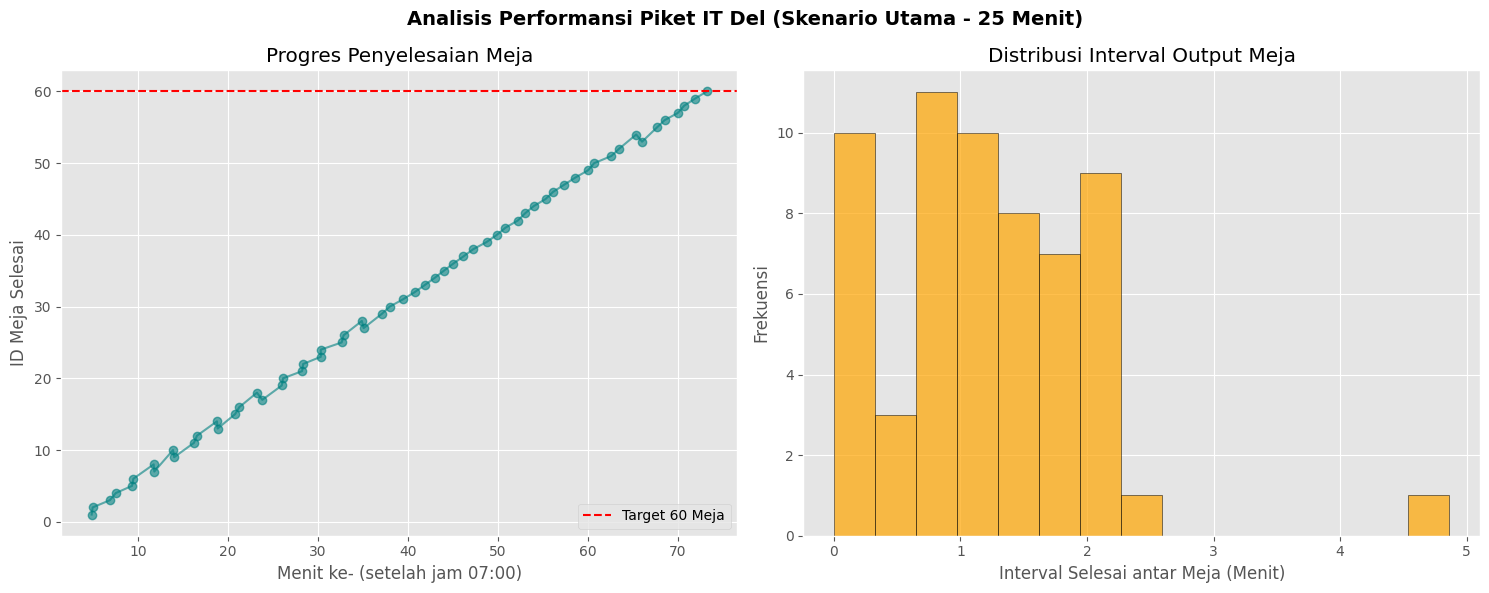

In [17]:
# ============================
# Menjalankan Simulasi
# ============================
print("DISCRETE EVENT SIMULATION - SISTEM PIKET IT DEL")
print("="*60)

# SKENARIO UTAMA (Kasus Awal dengan Target 25 Menit)
# Kita menggunakan parameter target_durasi sesuai fitur yang diminta
results, df, model = run_scenario(target_durasi=25.0)

# Visualisasi untuk skenario utama
visualize_results(df, model, "(Skenario Utama - 25 Menit)")


CONTOH 1: TARGET DURASI MINIMAL (15 MENIT)

MENJALANKAN SIMULASI PIKET IT DEL
Target Durasi  : 15.0 menit
Waktu Selesai  : 08:13:11
Total Durasi   : 73.19 menit
Status Target  : ❌ MELAMPAUI


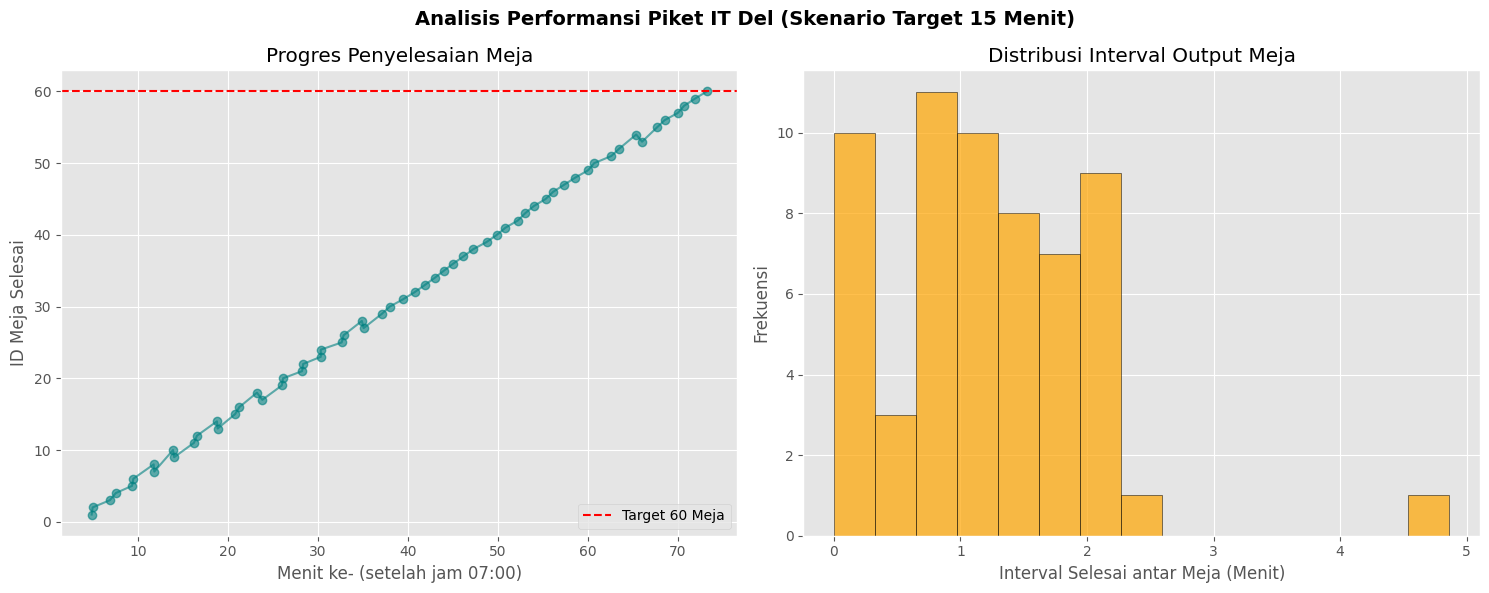


                      PERBANDINGAN SKENARIO TARGET DURASI                       
 Target (Min)  Realisasi (Min) Jam Selesai    Status  Selisih
           15            73.19    08:13:11 MELAMPAUI   -58.19
           20            73.19    08:13:11 MELAMPAUI   -53.19
           25            73.19    08:13:11 MELAMPAUI   -48.19
           30            73.19    08:13:11 MELAMPAUI   -43.19


In [18]:
# ======================================
# CONTOH SIMULASI dengan KONDISI BERBEDA
# ======================================

# Contoh 1: Mencoba target durasi minimal (15 Menit)
print("\n" + "="*60)
print("CONTOH 1: TARGET DURASI MINIMAL (15 MENIT)")
print("="*60)

results1, df1, model1 = run_scenario(target_durasi=15.0)

# Visualisasi untuk skenario target minimal
visualize_results(df1, model1, "(Skenario Target 15 Menit)")

# Tambahan: Menjalankan analisis sensitivitas untuk melihat perbandingan berbagai target
summary_table = sensitivity_analysis_piket()


CONTOH 2: TARGET DURASI 20 MENIT

MENJALANKAN SIMULASI PIKET IT DEL
Target Durasi  : 20.0 menit
Waktu Selesai  : 08:13:11
Total Durasi   : 73.19 menit
Status Target  : ❌ MELAMPAUI


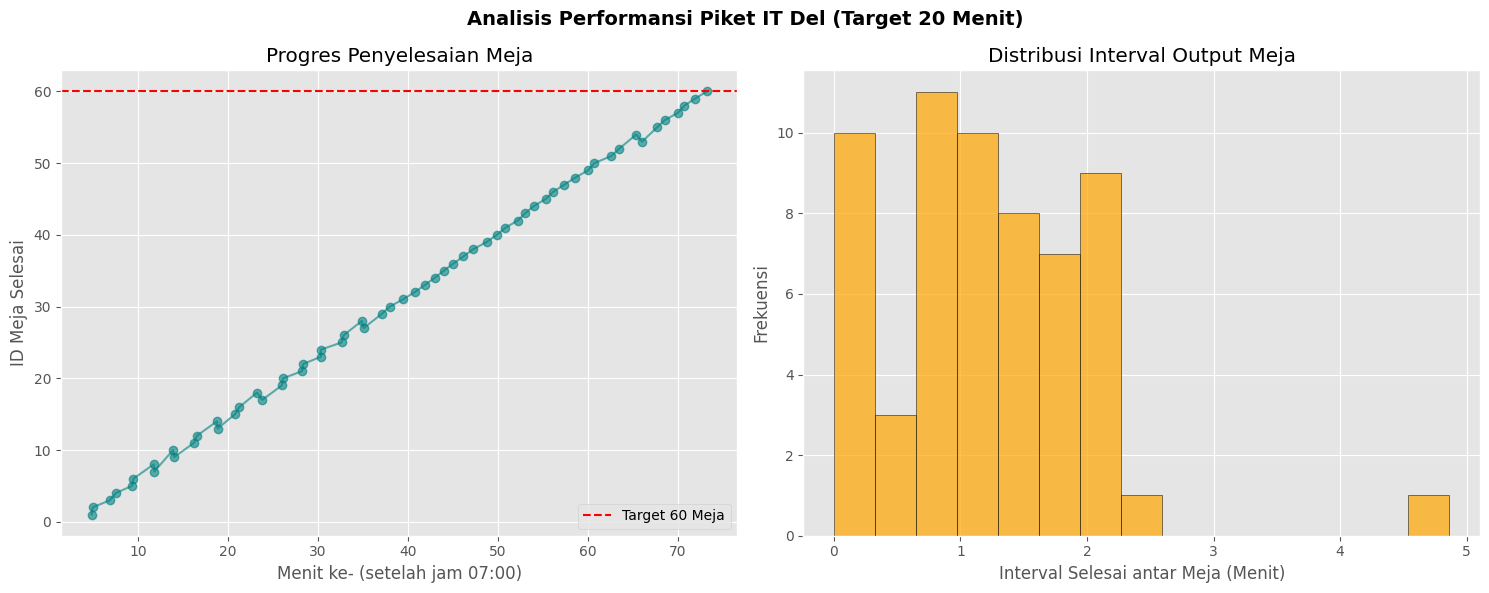

In [19]:
# ======================================
# CONTOH 2: Target Durasi 20 Menit
# ======================================
print("\n" + "="*60)
print("CONTOH 2: TARGET DURASI 20 MENIT")
print("="*60)

# Menjalankan skenario dengan target 20 menit
# Model akan mensimulasikan apakah 7 petugas mampu menyelesaikan 60 meja dalam waktu ini
results2, df2, model2 = run_scenario(target_durasi=20.0)

# Visualisasi untuk melihat apakah terjadi penumpukan (bottleneck) 
# pada proses pengangkutan atau pengisian nasi
visualize_results(df2, model2, "(Target 20 Menit)")


CONTOH 3: TARGET DURASI LONGGAR (30 MENIT)

MENJALANKAN SIMULASI PIKET IT DEL
Target Durasi  : 30.0 menit
Waktu Selesai  : 08:13:11
Total Durasi   : 73.19 menit
Status Target  : ❌ MELAMPAUI


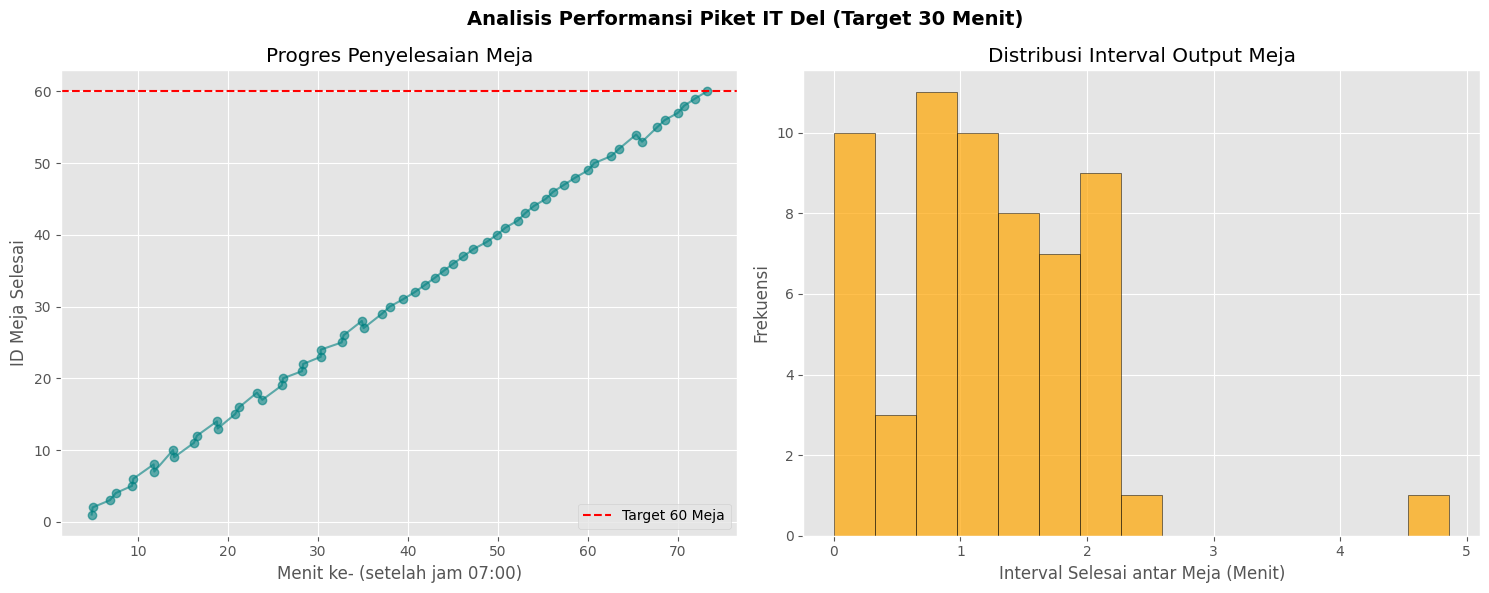

In [20]:
# ======================================
# CONTOH 3: Target Durasi Agresif (30 Menit)
# ======================================
print("\n" + "="*60)
print("CONTOH 3: TARGET DURASI LONGGAR (30 MENIT)")
print("="*60)

# Menjalankan skenario dengan target 30 menit
# Model akan mensimulasikan apakah dengan waktu yang lebih santai, 
# ritme kerja petugas menjadi lebih stabil.
results3, df3, model3 = run_scenario(target_durasi=30.0)

# Visualisasi untuk melihat distribusi waktu penyelesaian 
# meja pada target yang lebih longgar.
visualize_results(df3, model3, "(Target 30 Menit)")

In [21]:
# ============================
# ANALISIS SENSITIVITAS
# ============================
print("\n" + "="*80)
print("ANALISIS SENSITIVITAS TARGET DURASI PIKET")
print("="*80)

# Menjalankan analisis sensitivitas untuk melihat perbandingan 
# berbagai skenario target waktu (15, 20, 25, dan 30 menit)
sensitivity_df = sensitivity_analysis_piket()

# Catatan: Fungsi ini akan membandingkan Target vs Realisasi 
# untuk menentukan batas kemampuan optimal 7 petugas piket.


ANALISIS SENSITIVITAS TARGET DURASI PIKET

                      PERBANDINGAN SKENARIO TARGET DURASI                       
 Target (Min)  Realisasi (Min) Jam Selesai    Status  Selisih
           15            73.19    08:13:11 MELAMPAUI   -58.19
           20            73.19    08:13:11 MELAMPAUI   -53.19
           25            73.19    08:13:11 MELAMPAUI   -48.19
           30            73.19    08:13:11 MELAMPAUI   -43.19
